#**Twitter Sentiment Analysis Using Logistic Regression in Apache Spark MLlib**




# **Phase 1: Setup and Data Loading**

**Apache Spark and JDK SETUP**

In [35]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xvzf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark pyspark

spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.2-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.2-bin-hadoop3/R/lib/Spar

**ENV Variables**

In [36]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

**Spark Session**

In [37]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Tweets_Sentiment_Analysis").getOrCreate()

print("Apache Spark initialized successfully!")

Apache Spark initialized successfully!


**DataSet loading in Spark DataFrames**

In [38]:
dataset_path = "/content/twitter_training.csv"
df = spark.read.csv(dataset_path, header=False, inferSchema=True)

#**Phase 2: Data Preprocessing and Partitioning**

**Rename Columns**

In [39]:
df = df.withColumnRenamed("_c0", "ID") \
       .withColumnRenamed("_c1", "Topic") \
       .withColumnRenamed("_c2", "Sentiment") \
       .withColumnRenamed("_c3", "Tweet_Text")

df.printSchema()
df.show(5, truncate=100)

root
 |-- ID: integer (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- Tweet_Text: string (nullable = true)

+----+-----------+---------+---------------------------------------------------------+
|  ID|      Topic|Sentiment|                                               Tweet_Text|
+----+-----------+---------+---------------------------------------------------------+
|2401|Borderlands| Positive|    im getting on borderlands and i will murder you all ,|
|2401|Borderlands| Positive|      I am coming to the borders and I will kill you all,|
|2401|Borderlands| Positive|       im getting on borderlands and i will kill you all,|
|2401|Borderlands| Positive|      im coming on borderlands and i will murder you all,|
|2401|Borderlands| Positive|im getting on borderlands 2 and i will murder you me all,|
+----+-----------+---------+---------------------------------------------------------+
only showing top 5 rows



**Lowercasing, Cleaning, and Handling Null Values**

In [40]:
from pyspark.sql.functions import col, lower, regexp_replace, when

df_cleaned = df.withColumn("Cleaned_Text", lower(col("Tweet_Text")))
df_cleaned = df_cleaned.withColumn("Cleaned_Text", regexp_replace(col("Cleaned_Text"), "[^a-zA-Z0-9 ]", ""))

df_cleaned = df_cleaned.dropna()

**Mapping Sentiment to Binary Labels (0 or 1)**

In [41]:
from pyspark.sql.functions import lit, when, col

df_cleaned = df_cleaned.withColumn("Sentiment_Label",
                                   when(col("Sentiment") == "Negative", 0)  # Negative sentiment is labeled as 0
                                   .otherwise(1))  # All other sentiments (Neutral and Positive) are labeled as 1

df_cleaned = df_cleaned.withColumn("Sentiment_Label", col("Sentiment_Label").cast("integer"))

**Partition Data**

In [42]:
df_cleaned = df_cleaned.repartition(4)

df_cleaned.show(5, truncate=100)

+-----+--------------+----------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+---------------+
|   ID|         Topic| Sentiment|                                                                                          Tweet_Text|                                                                                        Cleaned_Text|Sentiment_Label|
+-----+--------------+----------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+---------------+
|  845|AssassinsCreed|Irrelevant|Been playing through Darksiders 2 and I've been loving the soundtrack.  Looked it up and of cours...|been playing through darksiders 2 and ive been loving the soundtrack  looked it up and of course ...|         

# **Phase 3: Distributed Database Implementation**

In [43]:
# Register DataFrame as SQL Table
df_cleaned.createOrReplaceTempView("tweets")

# Store as a distributed Parquet file
df_cleaned.write.mode("overwrite").parquet("/content/processed_tweets")

# **Phase 4: Query and Analysis**

**Query: Sentiment Distribution**

<ipython-input-44-ad6824d604c6>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_count["Sentiment"], y=sentiment_count["count"], palette="viridis")


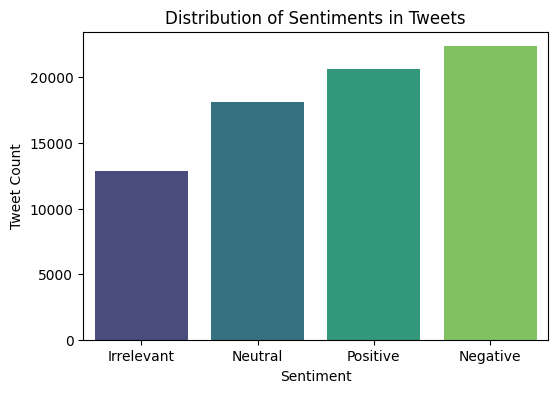

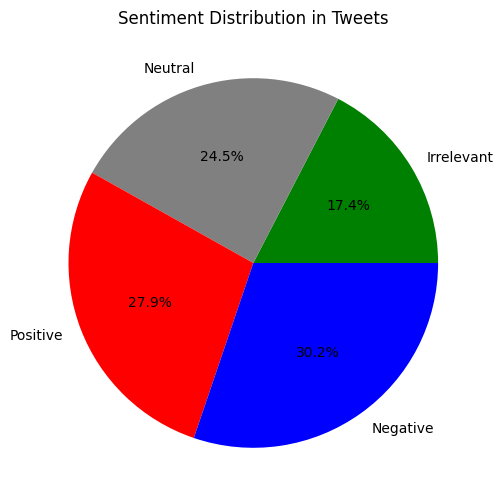

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_count = spark.sql("SELECT Sentiment, COUNT(*) AS count FROM tweets GROUP BY Sentiment").toPandas()

# Bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_count["Sentiment"], y=sentiment_count["count"], palette="viridis")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.title("Distribution of Sentiments in Tweets")
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_count["count"], labels=sentiment_count["Sentiment"], autopct='%1.1f%%', colors=["green", "gray", "red", "blue"])
plt.title("Sentiment Distribution in Tweets")
plt.show()

**Query: Tweet Length Analysis**

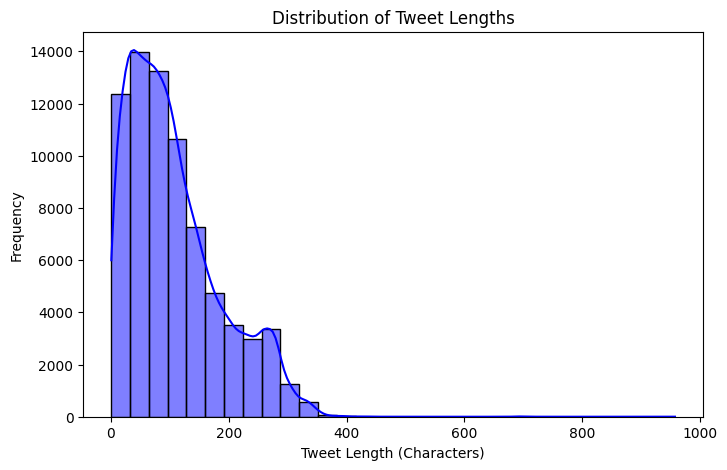

In [45]:
tweet_length_df = spark.sql("SELECT LENGTH(Tweet_Text) AS tweet_length FROM tweets").toPandas()

# Histogram of tweet lengths
plt.figure(figsize=(8,5))
sns.histplot(tweet_length_df["tweet_length"], bins=30, kde=True, color="blue")
plt.xlabel("Tweet Length (Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.show()

**Query: Most Common Words in Tweets**

<ipython-input-46-7bf2e1a103d9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=word_count_pdf["word"], x=word_count_pdf["count"], palette="mako")


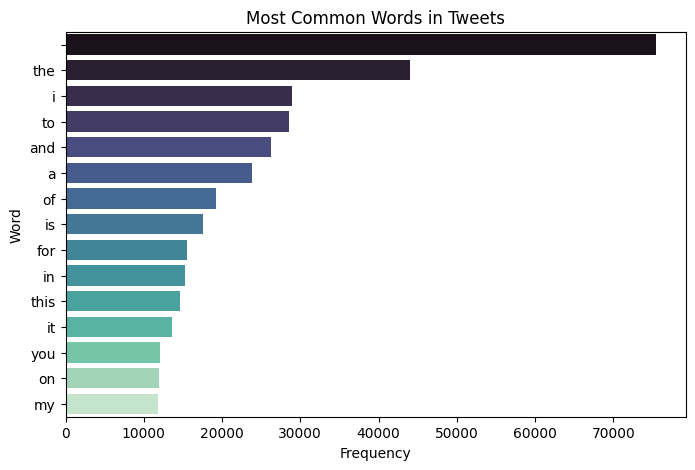

In [46]:
from pyspark.sql.functions import split, explode

# Tokenize and explode words
word_count = df_cleaned.withColumn("words", split(col("Cleaned_Text"), " ")) \
                       .withColumn("word", explode(col("words"))) \
                       .groupBy("word").count().orderBy(col("count").desc())

# Convert to Pandas
word_count_pdf = word_count.limit(15).toPandas()

# Plot Most Common Words
plt.figure(figsize=(8,5))
sns.barplot(y=word_count_pdf["word"], x=word_count_pdf["count"], palette="mako")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Most Common Words in Tweets")
plt.show()

**Query: Sentiment vs. Tweet Length**

<ipython-input-47-b090aa7a13dd>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment", y="tweet_length", data=sentiment_length_df, palette="coolwarm")


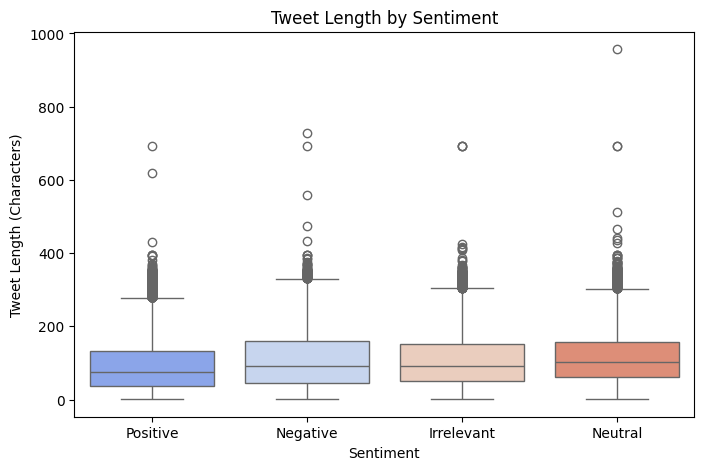

<ipython-input-47-b090aa7a13dd>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Sentiment", y="tweet_length", data=sentiment_length_df, palette="husl", inner="quartile")


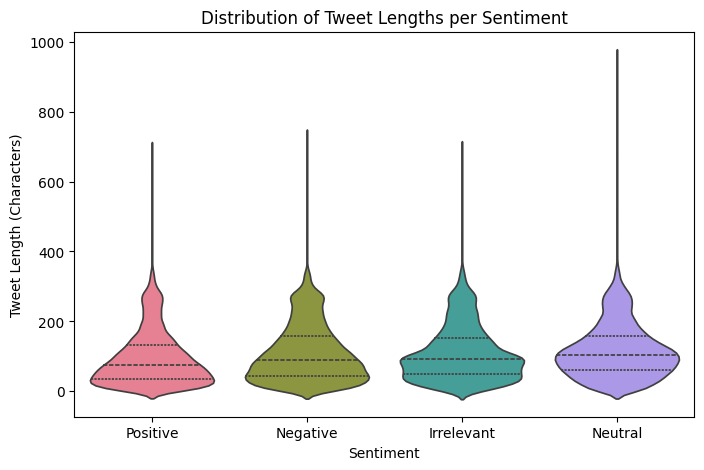

In [47]:
sentiment_length_df = spark.sql("""
    SELECT Sentiment, LENGTH(Tweet_Text) AS tweet_length
    FROM tweets
""").toPandas()

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x="Sentiment", y="tweet_length", data=sentiment_length_df, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length (Characters)")
plt.title("Tweet Length by Sentiment")
plt.show()

# Violin Plot for deeper distribution analysis
plt.figure(figsize=(8,5))
sns.violinplot(x="Sentiment", y="tweet_length", data=sentiment_length_df, palette="husl", inner="quartile")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length (Characters)")
plt.title("Distribution of Tweet Lengths per Sentiment")
plt.show()

# **Phase 5: AI Model Training and Evaluation**

In [48]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Convert text column into numerical features using TF-IDF
tokenizer = Tokenizer(inputCol="Cleaned_Text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")

# Train a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Sentiment_Label")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Split data into training and test sets
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment_Label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Evaluate Precision, Recall, and F1-score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment_Label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment_Label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment_Label", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Display results
print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Model Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.89


**Confusion Matrix**

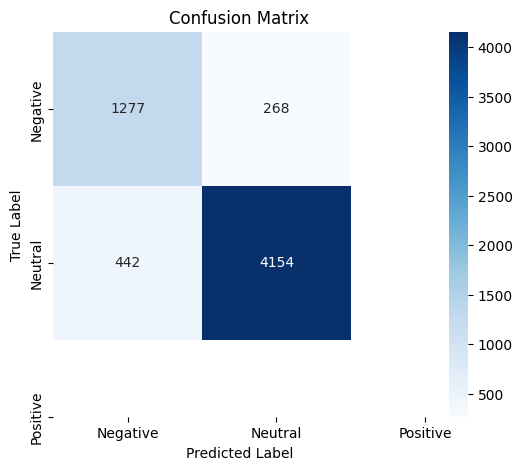

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert Spark DataFrame to Pandas
predictions_pd = predictions.select("Sentiment_Label", "prediction").toPandas()

# Compute Confusion Matrix
cm = confusion_matrix(predictions_pd["Sentiment_Label"], predictions_pd["prediction"])

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**ROC Curve**

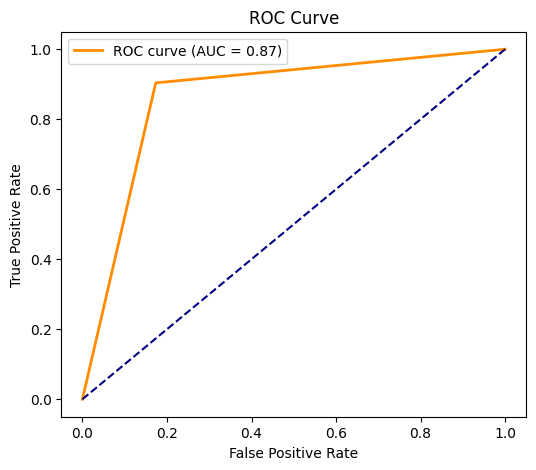

In [51]:
from sklearn.metrics import roc_curve, auc

# Extract probabilities for the positive class
predictions_pd["probability"] = predictions_pd["prediction"]

# Compute ROC curve
fpr, tpr, _ = roc_curve(predictions_pd["Sentiment_Label"], predictions_pd["probability"])
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Precision Recall Curve**

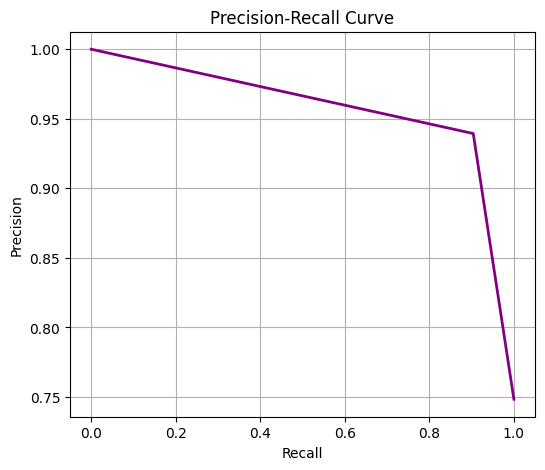

In [52]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(predictions_pd["Sentiment_Label"], predictions_pd["probability"])

# Plot Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

**Predictions**

In [53]:
predictions = model.transform(test_data)
predictions.select("Cleaned_Text", "Sentiment", "prediction").show(5)

+--------------------+---------+----------+
|        Cleaned_Text|Sentiment|prediction|
+--------------------+---------+----------+
|admit it subs you...|  Neutral|       1.0|
|love science fiction|  Neutral|       1.0|
|love speculative ...|  Neutral|       1.0|
|soim amazon for v...| Negative|       0.0|
|hated packing thi...| Positive|       1.0|
+--------------------+---------+----------+
only showing top 5 rows

